In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


## 1. Q-learning in Gym

Here we use the qlearning agent from before on taxi env from openai gym.
You will need to insert a few agent functions here.

In [346]:
import gym
env = gym.make("Taxi-v2")

n_actions = env.action_space.n

[2017-05-25 02:20:04,156] Making new env: Taxi-v2


In [347]:
from qlearning import QLearningAgent

agent = QLearningAgent(alpha=0.5,epsilon=0.25,discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

In [93]:
def play_and_train(env,agent,t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        a = <get agent to pick action given state s>
        
        next_s,r,done,_ = env.step(a)
        
        <train (update) agent for state s>
        
        s = next_s
        total_reward +=r
        if done:break
        
    return total_reward
    
        
    

mean reward -6.76


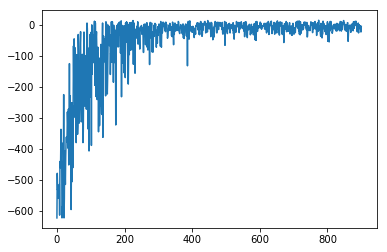

 11%|█         | 545/5000 [00:29<04:04, 18.23it/s]

In [348]:
rewards = []
for i in range(1000):
    rewards.append(play_and_train(env,agent))    
    if i %100 ==0:
        clear_output(True)
        print "mean reward",np.mean(rewards[-100:])
        plt.plot(rewards)
        plt.show()
        

### 1.1 reducing epsilon

Try decreasing agent epsilon over time to make him reach positive score.

The straightforward way to do so is to reduce epsilon every N games:
* either multiply agent.epsilon by a number less than 1 (e.g. 0.99)
* or substract a small value until it reaches 0

You can, of-course, devise other strategies.

__The goal is to reach positive reward!__

## 2. Expected Value SARSA

```<Please go to expected_value_sarsa.py and implement the missing lines in getValue method>```

In [ ]:
from expected_value_sarsa import EVSarsaAgent
agent = <initialize SarsaAgent just like Q-learning agent>
#Note that SARSA will likely need smaller learning rate!

In [ ]:
rewards = []
for i in range(1000):
    rewards.append(play_and_train(env,agent))    
    if i %100 ==0:
        clear_output(True)
        print "mean reward",np.mean(rewards[-100:])
        plt.plot(rewards)
        plt.show()
        

## 3. State space discretization

Use agent to train on CartPole-v0

This environment has a continuous number of states, so you will have to group them into bins somehow.

The simplest way is to use `round(x,n_digits)` (or numpy round) to round real number to a given amount of digits.

The tricky part is to get the n_digits right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

In [ ]:
env = gym.make("CartPole-v0")
n_actions = env.action_space.n

print("first state:%s"%(env.reset()))
plt.imshow(env.render('rgb_array'))

### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

In [ ]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s,r,done,_ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:break
            
all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    
    plt.hist(all_states[:,obs_i],bins=20)
    plt.show()

## Binarize environment

In [ ]:
from gym.core import ObservationWrapper
class Binarizer(ObservationWrapper):
    
    def _observation(self,state):    
        
        #state = <round state to some amount digits.>
        #hint: you can do that with round(x,n_digits)
        #you will need to pick a different n_digits for each dimension

        return tuple(state)

In [ ]:
env = Binarizer(gym.make("CartPole-v0"))

In [ ]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s,r,done,_ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:break
            
all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    
    plt.hist(all_states[:,obs_i],bins=20)
    plt.show()

## Learn

In [ ]:
from qlearning import QLearningAgent
agent = QLearningAgent(alpha=0.5,epsilon=0.25,discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

In [ ]:
rewards = []
for i in range(1000):
    rewards.append(play_and_train(env,agent))    
    if i %100 ==0:
        clear_output(True)
        print "mean reward",np.mean(rewards[-100:])
        plt.plot(rewards)
        plt.show()
        

## Bonus I: Experience replay

Q-learning and EV_sarsa are both off-policy algorithms. Therefore, they can find optimal policy even if they aren't trained exclusively on sessions generated under their current policy. 

This property can be used in many ways, one of them being experience replay trick: agent can be trained not only on immediate `<s,a,s',r>` state transition, but on any such transitions from previous sessions.

We'll store previous transitions in `experience` variable(see below) and sample from there.

In [ ]:
from random import choice
experience = [] #experience will be stored here as <state,aciton,next_state,reward> transitions


def play_and_train_exp_replay(env,agent,t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward
    - record <state,action,next_state,reward> tuples into experience
    """
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.getAction(s)
        next_s,r,done,_ = env.step(a)
        
        <record [s,a,next_s,r] into experience pool>
        <train agent on up to 5 random states from experience>
        
        s = next_s
        total_reward +=r
        if done:break
        
    return total_reward
    
        
    

In [ ]:
from qlearning import QLearningAgent
agent = QLearningAgent(alpha=0.5,epsilon=0.25,discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

In [ ]:
max_experience_size = 1000

rewards = []
for i in range(1000):
    
    rewards.append(play_and_train_exp_replay(env,agent))    
    
    <remove old sessions from experience if it's larger than max_experience_size. Try changing that variable.>
    
    if i %100 ==0:
        <adjust epsilon just like before>
        clear_output(True)
        print "mean reward",np.mean(rewards[-100:])
        plt.plot(rewards)
        plt.show()
        